In [1]:
import pickle
with open("vonMisesData_big.p", "rb") as input_file:
    [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters] = pickle.load(input_file)

In [2]:
# All imports here...
import numpy as np

import time

from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def BinSpikeRasters(Rasters, BinWidth=0.25, NBins=0) :
    # Rasters is a list of ndarrays, where each array contains spike times for a neuron
    if (NBins == 0) :
        b = 0.0;
        for spk_ts in Rasters :
            if (len(spk_ts) > 0) :
                b = max(b, (spk_ts[-1] / BinWidth))
        NBins = np.int(np.ceil(b))
    BinnedRasters = np.zeros((NBins, len(Rasters)))
    
    for k, spk_ts in enumerate(Rasters) :
        for s in spk_ts :
            BinnedRasters[np.int(s/BinWidth), k] += 1
    return BinnedRasters

In [4]:

t0 = time.time();
# Train model with first environment
NTrain = 500
NTest = 500
BinWidth = 0.25 # 250 ms bins
NBins = np.int(TrajLength / BinWidth)
TrainingData = []
for w in range(WorldParameters['NEnv']) :
    TrainingData.append([])
    for k in range(NTrain) :
        TrainingData[w].append(BinSpikeRasters(SpikeRasters[w][k], BinWidth=BinWidth, NBins=NBins))
t1 = time.time();
print("Time elapsed for binning: ", t1-t0)




Time elapsed for binning:  36.3095920085907


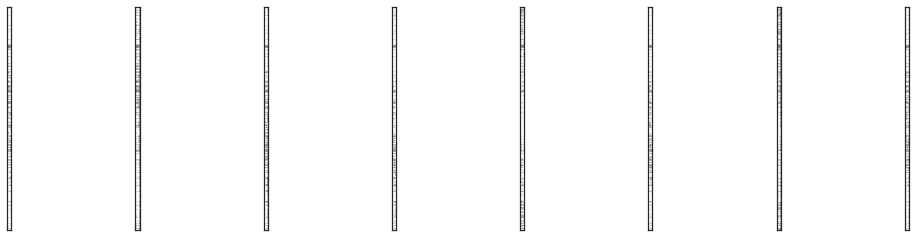

In [5]:
from hinton import hinton
f, axarr = plt.subplots(1,8)
for k in range(8):
    plt.sca(axarr[k])
    hinton(TrainingData[0][k])

In [6]:
StackedTrainingData = []
TrainingSequenceLengths = []
for w in range(WorldParameters['NEnv']) :
    StackedTrainingData.append(np.vstack(TrainingData[w]))
    TrainingSequenceLengths.append(np.zeros(NTrain, dtype=int))
    for idx,l in enumerate(TrainingData[w]) :
        (TrainingSequenceLengths[w][idx], ncols) = l.shape


In [7]:
# Compare different environments
Model = []
NStates = 10

transmat_init = np.zeros((NStates,NStates))
for i in range(NStates):
    for j in range(NStates) :
        if (i < j) :
            transmat_init[i][j] = 0.5**(np.abs(i-j))
        else :
            transmat_init[i][j] = 0.1**(np.abs(i-j))

from hmmlearn.utils import normalize
transmat_init = normalize(transmat_init, axis=1)


for w in range(WorldParameters['NEnv']) :
    model = hmm.PoissonHMM(n_components=NStates, n_iter=200, tol=1e-4, init_params='smc')
    model.transmat_ = transmat_init
    Model.append(model)
    #Model.append(hmm.GaussianHMM(n_components=NStates, covariance_type='diag', n_iter=100))


In [8]:
t0 = time.time();
   
for w in range(WorldParameters['NEnv']) :
    t1 = time.time();
    # Build an HMM instance and set parameters
    Model[w].fit(StackedTrainingData[w], lengths=TrainingSequenceLengths[w])
    t2 = time.time();
    print(t2-t1)
t3 = time.time();
print(t3-t0) # ~300 s total for 1000 neurons

63.735215187072754
70.21712493896484
47.29378008842468
70.01578307151794
46.76243710517883
298.02633810043335


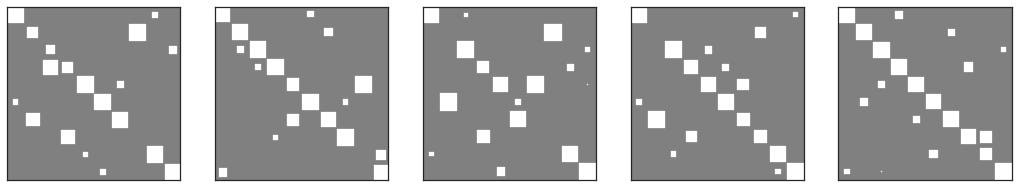

In [9]:
from hinton import hinton
f, axarr = plt.subplots(1,WorldParameters["NEnv"])
for k in range(WorldParameters["NEnv"]):
    plt.sca(axarr[k])
    hinton(Model[k].transmat_)


/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


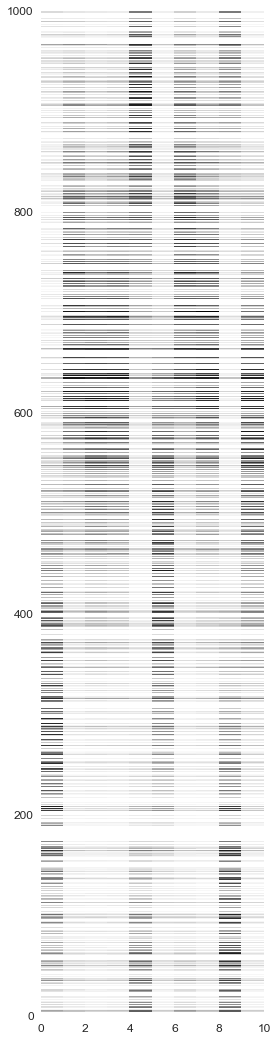

In [10]:
sns.set(rc={'figure.figsize': (4, 18),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
plt.pcolor(Model[0].means_.T)
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })


In [11]:
SequenceLL = []
t1 = time.time();
for w in range(WorldParameters['NEnv']) :
    SequenceLL.append(np.zeros(NTest))
    
for w in range(WorldParameters['NEnv']) :
    for i in range(NTest) :
        SequenceLL[w][i] = Model[0].score(BinSpikeRasters(SpikeRasters[w][NTrain + i]))
    t2 = time.time();
    print(t2-t1)


7.952548027038574
16.233034133911133
23.418437957763672
31.19733500480652
39.301146030426025


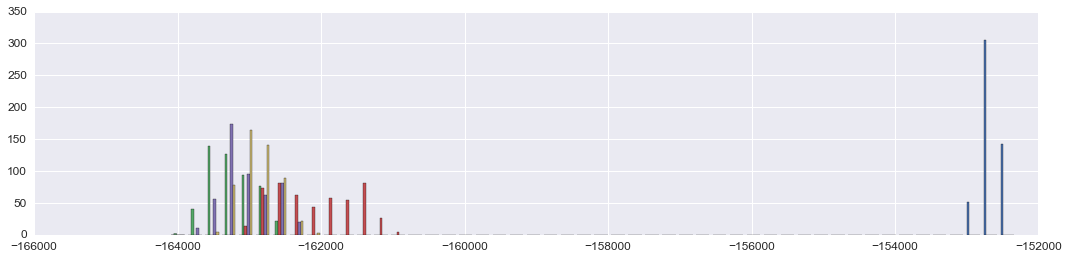

In [14]:
plt.hist(SequenceLL,bins=50);